# SciCite EDA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import torch
import re
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder


sns.set_theme()


# Torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
new_train_df = pd.read_json(path_or_buf=r'.\scicite\new_train.jsonl', lines=True)
train_df = pd.read_json(path_or_buf=r'.\scicite\train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'.\scicite\test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'.\scicite\dev.jsonl', lines=True)
train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


## Label Confidence

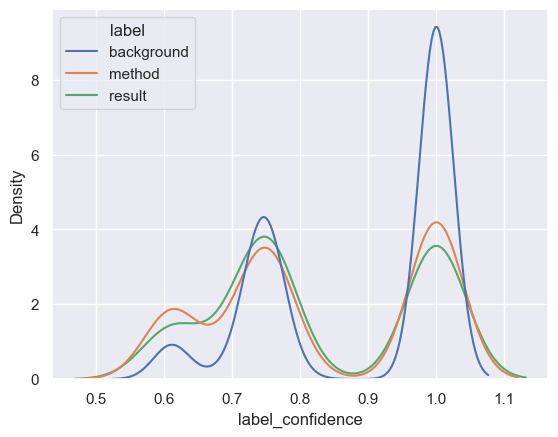

In [3]:
sns.kdeplot(data=train_df, x="label_confidence", hue="label", common_norm=False)
plt.show()

In [6]:
train_df["label_confidence"].mean()

0.876606045299006

## citeStart

<Axes: xlabel='citeStart', ylabel='Density'>

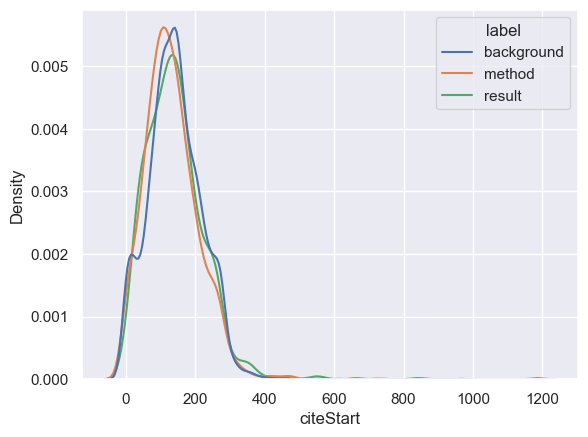

In [40]:
sns.kdeplot(data=train_df, x="citeStart", hue="label", common_norm=False)
plt.show()

## citeEnd

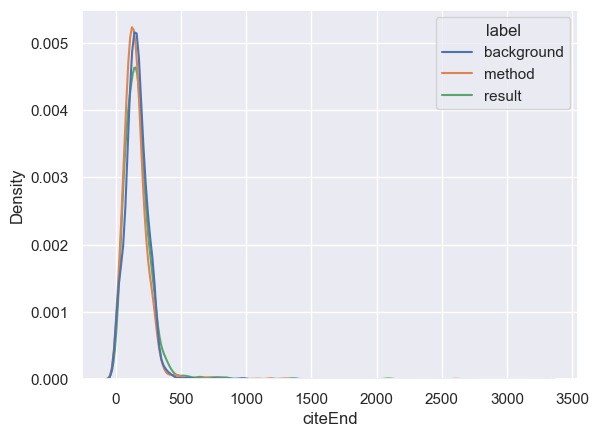

In [41]:
sns.kdeplot(data=train_df, x="citeEnd", hue="label", common_norm=False)
plt.show()

## Excerpt Index

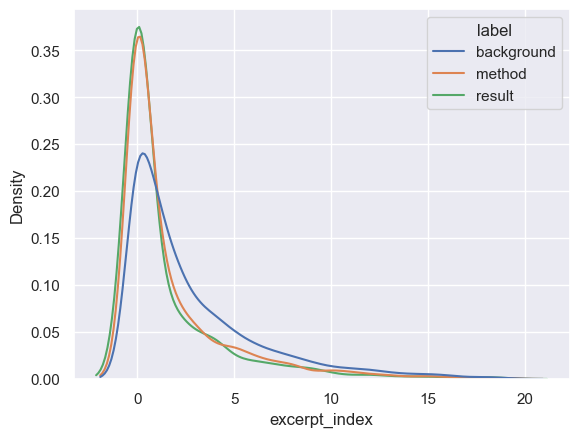

In [42]:
sns.kdeplot(data=train_df, x="excerpt_index", hue="label", common_norm=False)
plt.show()

## IsKeyCitation

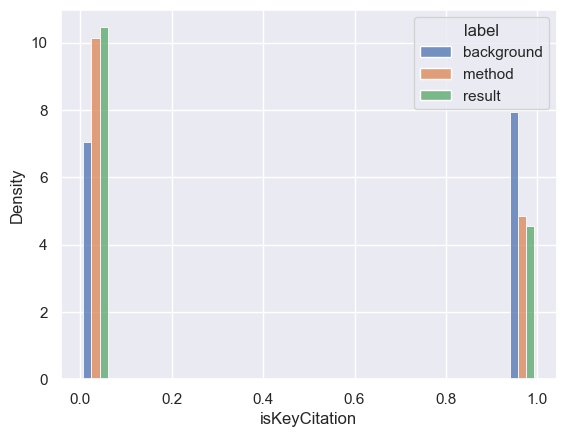

In [24]:
sns.histplot(data=train_df, x="isKeyCitation", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False)
plt.show()

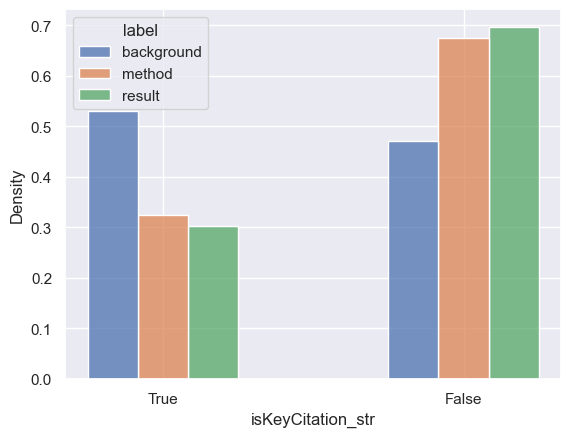

In [32]:
train_df["isKeyCitation_str"] = train_df["isKeyCitation"].apply(str)
sns.histplot(data=train_df, x="isKeyCitation_str", hue="label", multiple="dodge", shrink=.5, stat="density", common_norm=False)
plt.show()

## Source

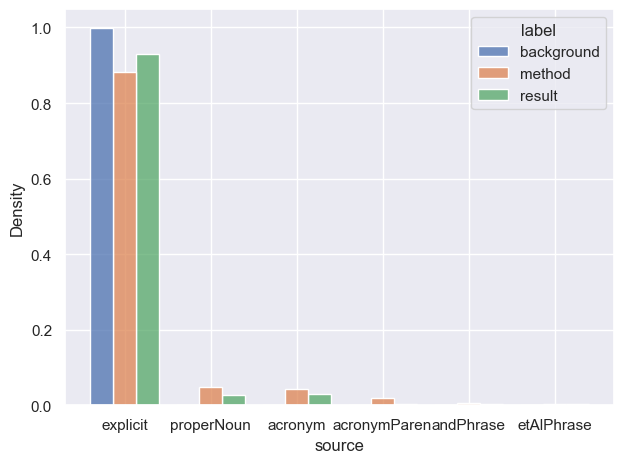

In [31]:
sns.histplot(data=train_df, x="source", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False)
plt.tight_layout()
plt.show()

* Proper noun not present in background.
* Essentially all are explicit in background.

## Section Name

In [3]:
def parse_section_name(raw_section_name):
    if raw_section_name is None or not raw_section_name.strip():
        return ""
    for i, c in enumerate(raw_section_name):
        if c.isalpha():
            break
    section_name = raw_section_name[i:]
    section_name = section_name.lower()
    return section_name.strip()


train_df["sectionName"] = train_df["sectionName"].apply(parse_section_name)

In [6]:
train_df[train_df["sectionName"] == "method"].label.value_counts()

method        90
background    37
Name: label, dtype: int64

In [8]:
90 / (90+37)

0.7086614173228346

In [7]:
train_df[train_df["sectionName"] == "experiments"].label.value_counts()

method        123
background     11
Name: label, dtype: int64

In [9]:
123 / (123+11)


0.917910447761194

In [17]:
train_df["sectionName"].value_counts()[:25]

discussion                2003
introduction              1682
methods                   1228
                           606
results                    555
results and discussion     179
experiments                134
method                     127
background                 115
methodology                 87
materials and methods       86
implementation              48
experimental setup          48
related work                45
experimental design         34
implementation details      15
present address:            14
experimental results        14
experiment                  13
numerical experiments       12
setup                       11
experimental settings       11
evaluation                   9
conclusions                  9
general discussion           7
Name: sectionName, dtype: int64

In [20]:
def convert_sn(sn):
    sn_mappings = {"discussion": {"discussion", "evaluation", "general discussion", "discussion and conclusions", "technical considerations", 
                                  "discussion, limitations and conclusion", 
                                 }, 
                   "introduction": {"introduction", "related work", "related works"}, 
                   "method": {"methods", "experiments", "methodology", "implementation", "experimental setup", "experimental design", 
                              "implementation details", "experiment", "numerical experiments", "setup", "experimental settings", "experimental setting", 
                              "experiment setup", 
                             },
                   "results": {"results", "results and discussion", "conclusions", "experimental results", "conclusion", "results & discussion", 
                               "findings", 
                              }, 
                   "background": {"background", "present address:"}, 
                   "material and methods": {"materials and methods"}
                  }
    for k, sns in sn_mappings.items():
        if sn in sns:
            return k
    return sn

train_df["sectionName"] = train_df["sectionName"].apply(convert_sn)

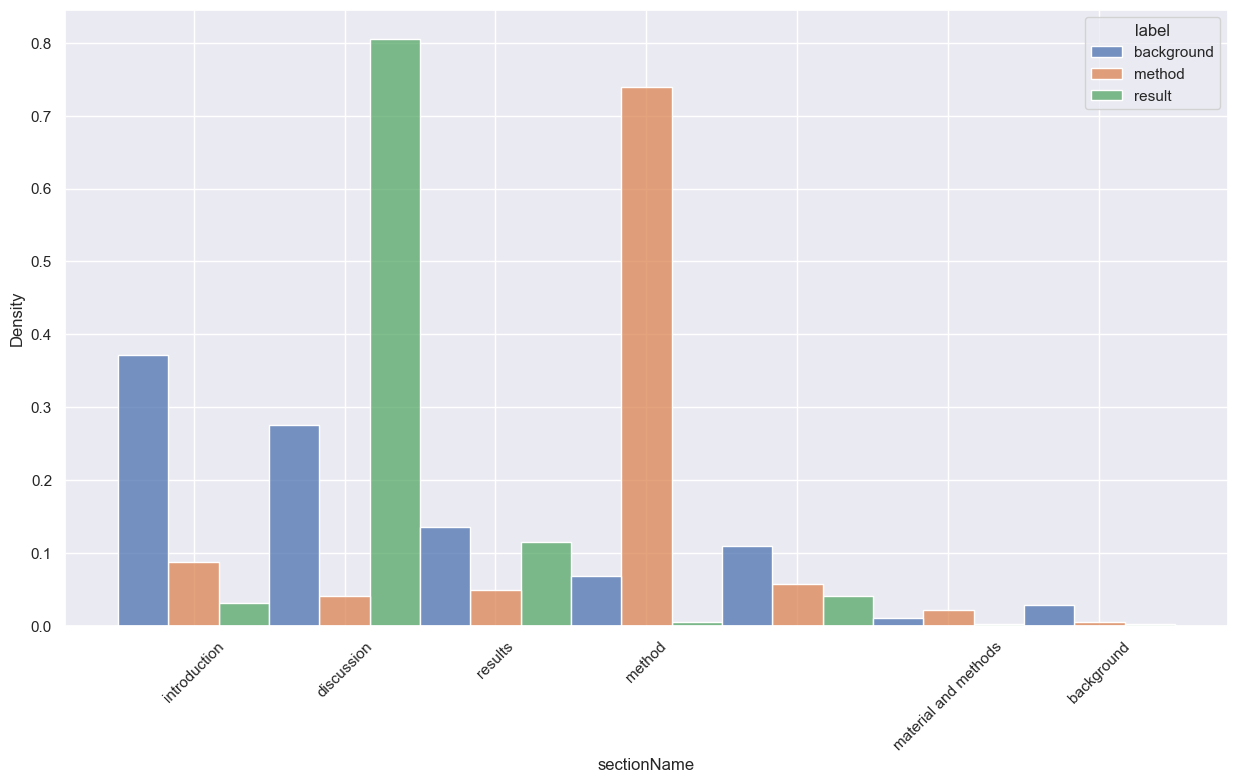

In [25]:
impt_names = set(train_df["sectionName"].value_counts()[:7].keys())
impt_df = train_df[train_df["sectionName"].isin(impt_names)]

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.histplot(data=impt_df, x="sectionName", hue="label", multiple="dodge", stat="density", common_norm=False)
plt.show()

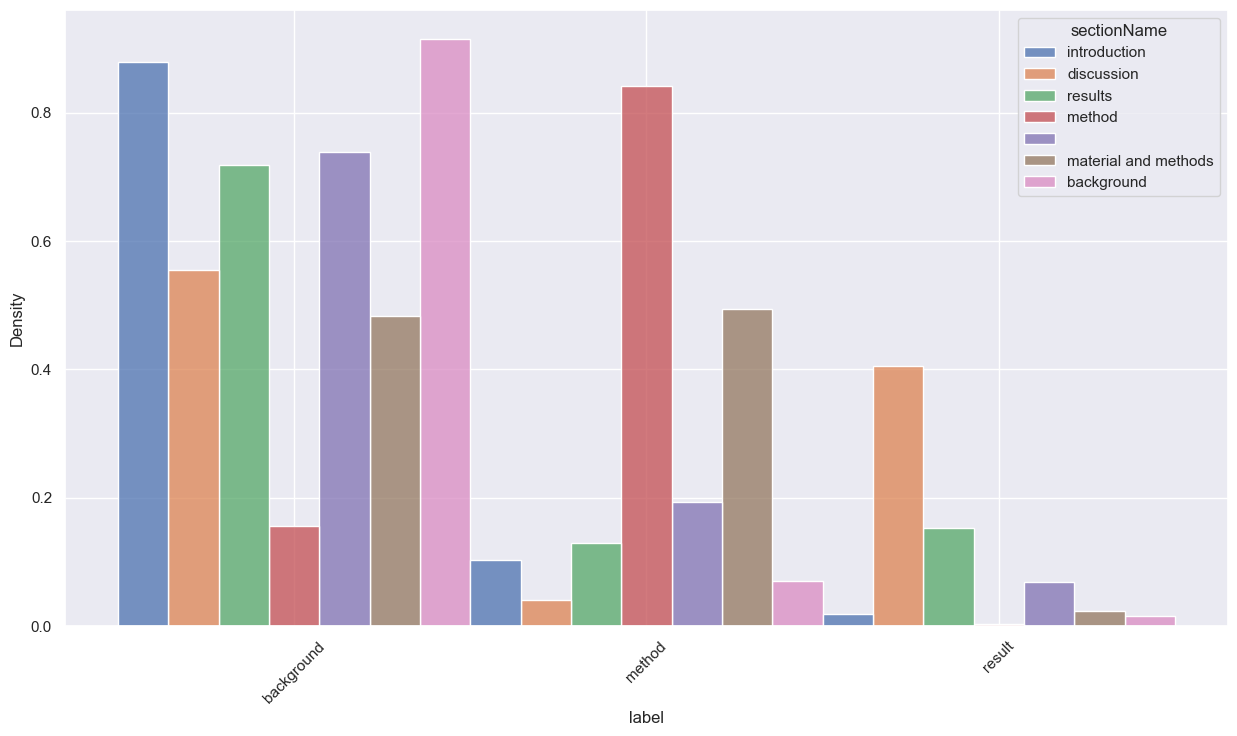

In [26]:
impt_names = set(train_df["sectionName"].value_counts()[:7].keys())
impt_df = train_df[train_df["sectionName"].isin(impt_names)]

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.histplot(data=impt_df, x="label", hue="sectionName", multiple="dodge", stat="density", common_norm=False)
plt.show()

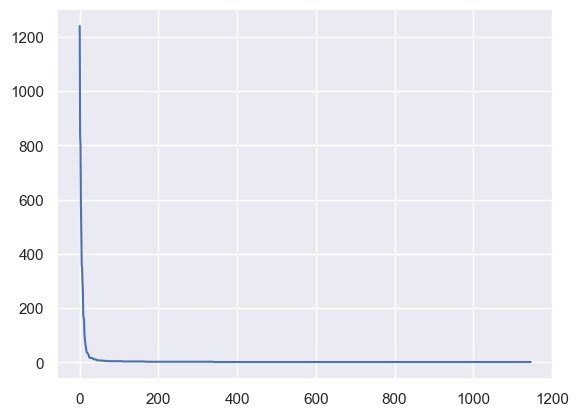

In [4]:
plt.plot(train_df["sectionName"].value_counts().values)

## Remove Citation Names

In [13]:
import spacy

nlp = spacy.load('en_core_web_sm')
# nlp.add_pipe('sentencizer')

In [14]:
def tokenize(doc, ner_labels, pos_labels):
    # Get count for each name entities
    ner_label_counts = {ner_label: 0 for ner_label in ner_labels}
    for ent in doc.ents:
        ner_label_counts[ent.label_] += 1

    # Get count for each POS
    pos_label_counts = {pos_label: 0 for pos_label in pos_labels}
    for word in doc:
        if word.pos_ in pos_labels:
            pos_label_counts[word.pos_] += 1
    
    # Get tokens
    tokens = {"tokens": [word.text for word in doc if not word.is_punct]}

    # Get vector representation
    vector = {"vector": doc.vector}

    # Merge into 1 single dictionary
    res = tokens | vector | glove_vector | ner_label_counts | pos_label_counts

    # embeddings = [glove.get_vecs_by_tokens(tokens, lower_case_backup=True) for tokens in train['Tokens'].tolist()]
    # test_embeddings = [glove.get_vecs_by_tokens(tokens, lower_case_backup=True) for tokens in test['Tokens'].tolist()]
    return res

# # Add length of each text
# train_len = train["Text"].apply(len)
# train.insert(len(train.columns), "length", train_len)
# test_len = test["Text"].apply(len)
# test.insert(len(test.columns), "length", test_len)

# ner_labels = nlp.pipeline[5][-1].labels
# pos_labels = {'ADJ', 'ADP', 'ADV', 'AUX', 'DET', 'NOUN', 'NUM', 'PRON', 'PUNCT', 'VERB'}
# train = train.join(pd.DataFrame([tokenize(doc, ner_labels, pos_labels) for doc in nlp.pipe(train["Text"])]))
# test = test.join(pd.DataFrame([tokenize(doc, ner_labels, pos_labels) for doc in nlp.pipe(test["Text"])]))
# train

In [52]:
text = train_df.iloc[2]["string"]
text

'The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.'

In [66]:
text = train_df.iloc[10]["string"]
print(text)

docs = nlp.pipe([text])
for doc in docs:
    print([(ent.text, ent.label_) for ent in doc.ents])

…lifetimes, whereas indirect benefits refer to benefits to genetically related recipients; i.e., benefits that increase the inclusive fitness of benefactors but typicaly imply fitness costs that are not compensated during the benefactors’ lifetimes (Hamilton 1964; Trivers 1971; West et al. 2007).
[('typicaly', 'GPE'), ('Hamilton', 'PERSON'), ('Trivers 1971', 'ORG'), ('West et al', 'LOC'), ('2007', 'DATE')]


In [16]:
def remove_cites(text):
    """
    There are still references that are not in the brackets.
    """
    text = re.sub("\s*\[[^\[]*\]", "", text)
    text = re.sub("\s*\([^\(]*\)", "", text)
    return text

a = train_df["string"].apply(remove_cites)

i = 1

print(train_df["string"].iloc[i])

a.iloc[i]

In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological
robinson et al.: genomic regions influencing root traits in barley 11 of 13
maturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.


'In the study by Hickey et al., spikes were sampled from the field at the point of physiological\nrobinson et al.: genomic regions influencing root traits in barley 11 of 13\nmaturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.'

In [65]:
def get_cite_count(text):
    tot_count = 0
    for cite in re.findall("\[[\d|,|\-|\–|\s]+\]", text):
        count = len(re.findall(r"\d+", cite))
        for pair in re.findall(r"(\d+)\s*[-|–]\s*(\d+)", cite):
            count += int(pair[1]) - int(pair[0]) - 1
        tot_count += count
    return tot_count

train_df["cite_count"] = train_df["string"].apply(get_cite_count)

In [66]:
train_df[["label", "cite_count"]]

,label,cite_count
0,background,7
1,background,0
2,background,0
3,background,0
4,background,5
...,...,...
8238,background,0
8239,background,1
8240,background,0
8241,method,0


In [70]:
for n in ("background", "method", "result"):
    x = train_df[train_df["label"] == n].cite_count
    print(n, x.mean(), x.median())

background 1.062603305785124 0.0
method 0.9533565823888405 0.0
result 0.9170423805229937 0.0


<Axes: xlabel='cite_count', ylabel='Density'>

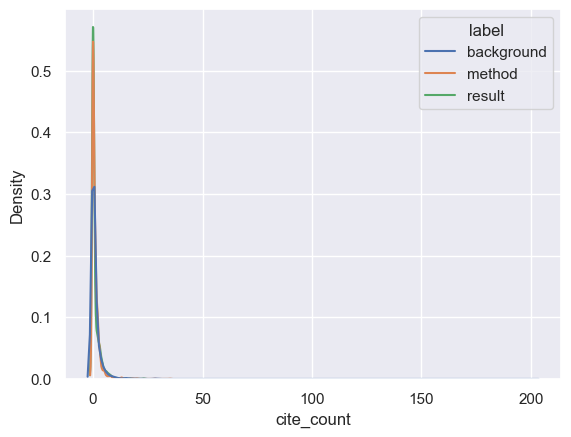

In [67]:
sns.kdeplot(data=train_df, x="cite_count", hue="label", common_norm=False)

## Generate images

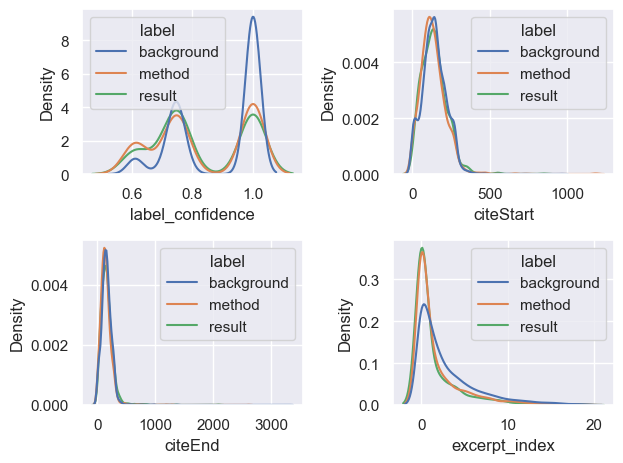

In [16]:
fig, axes = plt.subplots(2, 2)
# sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)
sns.kdeplot(data=train_df, x="label_confidence", hue="label", common_norm=False, ax=axes[0, 0])
sns.kdeplot(data=train_df, x="citeStart", hue="label", common_norm=False, ax=axes[0, 1])
sns.kdeplot(data=train_df, x="citeEnd", hue="label", common_norm=False, ax=axes[1, 0])
sns.kdeplot(data=train_df, x="excerpt_index", hue="label", common_norm=False, ax=axes[1, 1])
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2, 2)
# sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)
sns.kdeplot(data=train_df, x="label_confidence", hue="label", common_norm=False, ax=axes[0, 0])
sns.kdeplot(data=train_df, x="citeStart", hue="label", common_norm=False, ax=axes[0, 1])
sns.kdeplot(data=train_df, x="citeEnd", hue="label", common_norm=False, ax=axes[1, 0])
sns.kdeplot(data=train_df, x="excerpt_index", hue="label", common_norm=False, ax=axes[1, 1])
plt.tight_layout()

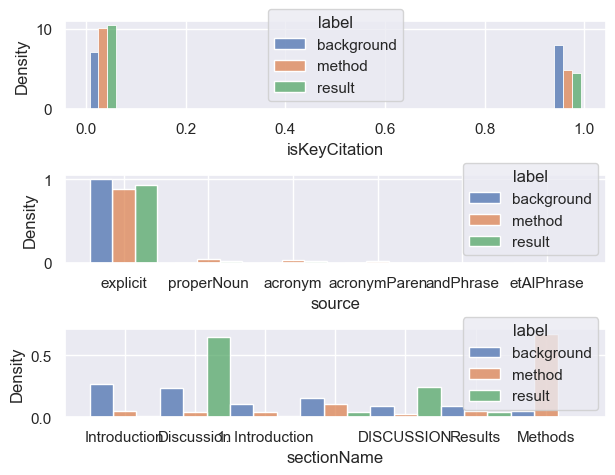

In [23]:
fig, axes = plt.subplots(3, 1)
fig.figsize=(15,8)
# fig.rotation=45)
sns.histplot(data=train_df, x="isKeyCitation", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False, ax=axes[0])
sns.histplot(data=train_df, x="source", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False, ax=axes[1])


impt_names = set(train_df["sectionName"].value_counts()[:7].keys())
impt_df = train_df[train_df["sectionName"].isin(impt_names)]

sns.histplot(data=impt_df, x="sectionName", hue="label", multiple="dodge", stat="density", common_norm=False, ax=axes[2])
plt.tight_layout()
plt.show()